# Portfolio 5: Network Flow with Congestion

We consider the minimum cost network flow problem with congestion.  
The minimum cost network flow problem is a linear programming problem, and the addition of congestion turns it into a quadratic programming problem.  The problem is somewhat similar to the maximum flow problem and the optimal transport problem which were discussed in class.

## Problem statement

Let $G = (V, E)$ be a network with $n = |V|$ nodes and $m = |E|$ edges.  
For each node $i = 0, \dots n-1$, let $b_i$ be its supply/demand value.  
$b_i > 0$ represents supply, $b_i < 0$ represents demand, and $b_i = 0$ represents a node without any supply or demand.
We assume that the total supply is equal to the total demand, i.e. $\sum_i b_i = 0$.  
For each edge $(i,j)$, let $c_k$ be the coefficient of the cost to move supply along that edge. 
Let $A$ be the node-arc incidence matrix. 

**Decision Variables:**
Let $x_k$ be the flow along edge $k$.  

**Objective function:**  
We assume the cost to move $x_k$ units of supply along edge $x_k$ is proportional to the amount of supply being moved, i.e. the cost is $c_k x_k^2$.
We wish to minimize the total cost: $\min \sum_k c_kx_k^2$
This makes the problem a quadratic programming problem.

**Constraints:**  
The flow into and out of a node must be equal to the supply/demand at that node:
$$
\sum_{e_k = (j,i)} x_k - \sum_{e_k = (i,j)} x_k = -b_i \ , \ \ i=0,\dots,n-1
$$


This problem statement is largely taken from the lecture of Jan 26.

## Computing Solutions

In [4]:
import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#!pip install cvxpy

  Using cached cvxpy-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.8 kB)
  Using cached osqp-0.6.5-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached ecos-2.0.13-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
  Using cached clarabel-0.7.1-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.6 kB)
  Using cached scs-3.2.4.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached pybind11-2.12.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached qdldl-0.1.7.post0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.7 kB)
Using cached cvxpy-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
Using cached clarabel-0.7.1-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Using cached ecos-2.0.13-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x

We construct some simple data to demonstrate the algorithm.  

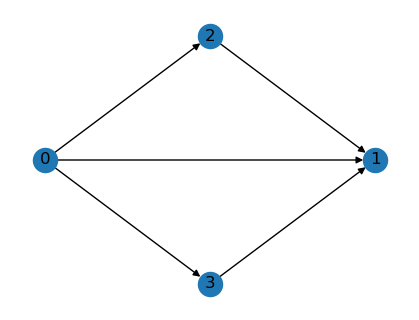

In [8]:
nodes = [0,1,2,3]
coordinates = [(0,0),(2,0),(1,1),(1,-1)]
edges = [(0,1),(0,2),(0,3),(2,1),(3,1)]
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
plt.figure(figsize=(4,3))
nx.draw(G,pos=coordinates,with_labels=True)

In [9]:
A = nx.incidence_matrix(G,oriented=True).toarray()
A

array([[-1., -1., -1.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  1.],
       [ 0.,  1.,  0., -1.,  0.],
       [ 0.,  0.,  1.,  0., -1.]])

In [10]:
b = np.array([10,-10,0,0])
c = np.array([3,2,2,2,2])

There are 10 units of supply at the source node 0, and 10 units of demand at the sink node 1. Nodes 2 and 3 are shipping nodes.  
The cost is 3 for the edge (0,1) and 2 for all other edges.  
The solution without congestion is to send all 10 units of supply through the edge (0,1). Without congestion, the cost to send any unit of supply from 0 to 1 is 3 when using that edge, but 4 when using the routes through nodes 2 or 3.

We use `cvxpy` to compute the solution with congestion.  
To use it, we must convert the form of the objective function: the cost vector c becomes a diagonal matrix C, and optimize $x^TCx$.  

In [20]:
n,m = A.shape
C = np.diag(c)
x = cp.Variable(m)
obj = cp.Minimize(cp.quad_form(x,C))
constraints = [A@x == -b, x >= 0]
problem = cp.Problem(obj,constraints)

In [21]:
problem.solve()

120.0

In [25]:
x.value

array([4., 3., 3., 3., 3.])

The optimal solution with congestion does not exclusively use the (0,1) edge. 
It sends 4 units of supply through (0,1) (cost $3 \times 4^2 = 48$), and 3 units of supply through each of nodes 2 and 3 (cost $2 \times 3^2  + 2 \times 3^2= 36$ per branch) for a total cost of 120.
The cost to send all of the supply through the (0,1) edge would be $3\times 10^2 = 100$, far larger than the optimal solution with congestion.

We can consider a more complex example: Figure 14.1 from Vanderbei p. 230.
The code to generate the graph is taken from the lecture of Jan 24.

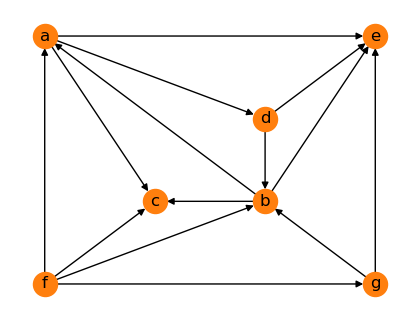

In [5]:
nodes = list('abcdefg')
coordinates = {'a':(0,3),'b':(2,1),'c':(1,1),'d':(2,2),'e':(3,3),'f':(0,0),'g':(3,0) }
edges = [('a','c'),('a','d'),('a','e'),('b','a'),('b','c'),('b','e'),('d','b'),
         ('d','e'),('f','a'),('f','b'),('f','c'),('f','g'),('g','b'),('g','e')]
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
plt.figure(figsize=(4,3))
nx.draw(G,pos=coordinates,with_labels=True,node_color='C1')

In [11]:
A = nx.incidence_matrix(G,oriented=True).toarray()
print(A)

[[-1. -1. -1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1. -1. -1.  1.  0.  0.  1.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1. -1.]]


In [7]:
b = np.array([0,0,-6,-6,-2,9,5])
c = np.array([48,28,10,7,65,7,38,15,56,48,108,24,33,19])

In [8]:
n,m = A.shape
C = np.diag(c)
x = cp.Variable(m)
obj = cp.Minimize(cp.quad_form(x,C))
constraints = [A@x == -b, x >= 0]
problem = cp.Problem(obj,constraints)

In [9]:
problem.solve()

3604.3275161285587

In [12]:
np.round(x.value,2)

array([ 1.79,  6.  , -0.  ,  4.73,  1.83, -0.  , -0.  , -0.  ,  3.06,
        2.88,  2.38,  0.69,  3.69,  2.  ])

The optimal solution calculated for the case without congestion is `array([ 6.,  6.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  3., 2.])`, with the optimal cost being 1109 (from the lecture on 24 Jan).

## Comparison to Network Flow without Congestion

The solutions with congestions differ significantly from the solutions without.  
When congestion is added, the flow is more spread out, and routes with higher cost coefficients may be used. Congestion causes the cost of using an edge to increase with the amount of supply being sent through it, so it will cause the supply to be spread out over a larger number of edges.
Without congestion, the minimum-cost path between any source and sink is independent of the amount of supply being sent through it, so optimal routes will send the full supply being sent from that source to that sink via a single path (barring edge cases where the minimum-cost path is not unique).
The addition of congestion means that the optimal path depends on how much supply is being sent, which leads to the supply being diverted through multiple paths to reach the sink.

In the second example, the optimal solution contains many non-integer flow values, even though all the cost and supply/demand values are integers. This does not happen without congestion.
The Integrality Theorem (Vanderbei p. 247) guarantees that if the supply and demand values are all integers, then the optimal solution assigns an integer flow to every arc. This is a consequence of the way that the optimal flows are calculated - they are calculated as 
Since congestion breaks the linearity of the system, the Integrality Theorem no longer applies. Conceptually, the quadratic nature of the objective function may cause the optimal solution to occur in the middle of the feasible region, far from any vertex. There is no guarantee that the optimal solution will have integer valued flows, as in the second example above.

## References

Vanderbei, Robert J. *Linear Programming: Foundations and Extensions*, 5th ed. Springer, 2020.

Walls, Patrick. "Graphs". Math 441. Mathematical Modelling: Discrete Optimization Problems. 24 January 2024, University of British Columbia. Lecture.  

Walls, Patrick. "Network Flows". Math 441. Mathematical Modelling: Discrete Optimization Problems. 26 January 2024, University of British Columbia. Lecture.  